In [ ]:
from dolfinx import mesh, fem
from dolfinx.fem import petsc as fem_petsc
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import numpy as np
import matplotlib.pyplot as plt

# --- Parametri ---
c = 1.0          # velocità
L = 2.0          # lunghezza dominio
nx = 500         # numero intervalli
T = 1            # tempo finale
dt = 0.001       # passo temporale
nt = int(T / dt) + 1
t_vals = np.linspace(0., T, nt)
plot_times = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]


# --- Mesh e spazio ---
domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])
V = fem.functionspace(domain, ("Lagrange", 1))

# --- Condizioni al contorno Dirichlet u=0 ---
u_bc = fem.Function(V)
u_bc.x.array[:] = 0.0
facets = mesh.locate_entities_boundary(
    domain, dim=0,
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
)
dofs = fem.locate_dofs_topological(V, entity_dim=0, entities=facets)
bc = fem.dirichletbc(u_bc, dofs)

# --- Funzioni temporali ---
u0 = fem.Function(V)  # u^{n-1}
u1 = fem.Function(V)  # u^{n}
u_new = fem.Function(V)  # u^{n+1}

# --- Inizializzazione ---
x_coords = V.tabulate_dof_coordinates()[:, 0]
u1.x.array[:] = gaussian(x_coords)
u0.x.array[:] = u1.x.array  # velocità iniziale = 0

# --- Variabili per forma debole ---
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# --- Matrice A (costante) ---
a_form = (u * v / dt**2) * ufl.dx + c**2 * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
A = fem.petsc.assemble_matrix(fem.form(a_form), bcs=[bc])
A.assemble()

solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType("preonly")
solver.getPC().setType("lu")

# --- Loop temporale ---
for t_current in t_vals:

    # Grafico nei tempi richiesti
    if np.any(np.isclose(t_current, plot_times, atol=dt / 2)):
        plt.plot(x_coords, u1.x.array, label=f"t={t_current:.2f}")

    # Salta il passo temporale 0
    if np.isclose(t_current, T):
        break

    # --- Termine destro b ---
    L_form = (2.0 * u1 * v / dt**2 - u0 * v / dt**2) * ufl.dx
    b = fem.petsc.assemble_vector(fem.form(L_form))
    fem.petsc.apply_lifting(b, [fem.form(a_form)], bcs=[[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [bc])

    # --- Risoluzione per u_new ---
    solver.solve(b, u_new.x.petsc_vec)
    u_new.x.scatter_forward()

    # --- Aggiornamento per passo successivo ---
    u0.x.array[:] = u1.x.array
    u1.x.array[:] = u_new.x.array

# --- Plot finale ---
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.show()


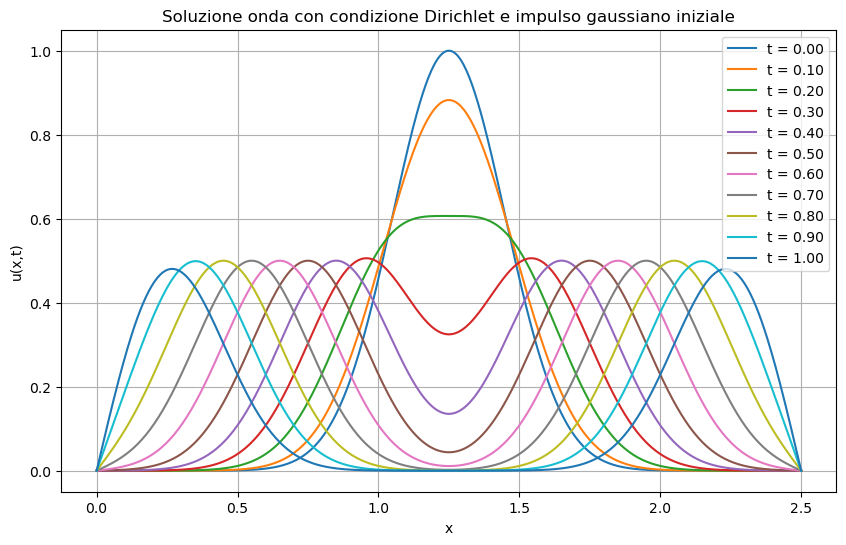

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri
L = 2.5
c = 1.0
N_modes = 50
nx = 500
x = np.linspace(0, L, nx)

# Funzione iniziale: impulso gaussiano centrato a L/2
sigma = 0.2
f = np.exp(-((x - L/2)**2) / (2*sigma**2))

# Calcolo coefficienti A_n
A = np.zeros(N_modes)
for n in range(1, N_modes+1):
    A[n-1] = 2/L * np.trapezoid(f * np.sin(n * np.pi * x / L), x)

# Funzione soluzione u(x,t)
def u_xt(x, t):
    u = np.zeros_like(x)
    for n in range(1, N_modes+1):
        omega_n = n * np.pi * c / L
        u += A[n-1] * np.cos(omega_n * t) * np.sin(n * np.pi * x / L)
    return u

# Tempi in cui calcolare la soluzione
times = np.linspace(0., 1., 11)

plt.figure(figsize = (10,6))
for t in times:
    plt.plot(x, u_xt(x, t), label=f't = {t:.2f}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Soluzione onda con condizione Dirichlet e impulso gaussiano iniziale')
plt.legend()
plt.grid(True)
plt.show()

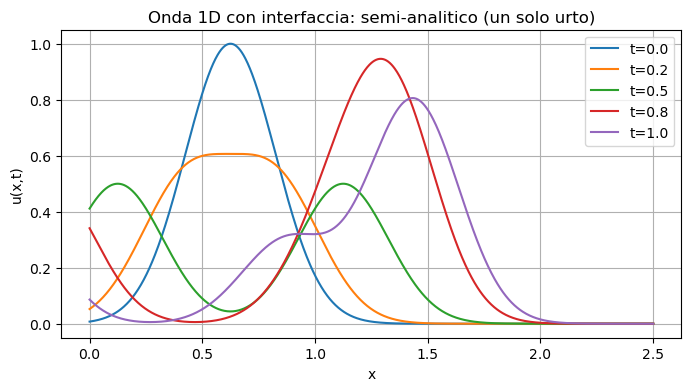

In [1]:
import numpy as np
import matplotlib.pyplot as plt

L   = 2.5
x   = np.linspace(0, L, 1000)
T   = 1.0
x0  = L/2          # interfaccia
c1, c2 = 1.0, 0.5

def gaussian(z, sigma):
    return np.exp(-0.5*(z/sigma)**2)

x_c   = L/4        # centro iniziale a sinistra dell’interfaccia
sigma = 0.2

# coefficienti di ampiezza per questa PDE: u_tt = d_x(c^2 u_x)
rA = (c1**2 - c2**2) / (c1**2 + c2**2)
tA = (2*c1**2)      / (c1**2 + c2**2)

def u_semianalytic(x, t):
    # componente SINISTRA (sempre presente)
    u_left = 0.5 * gaussian(x - (x_c - c1*t), sigma)  # che viaggia verso sinistra
    # componente DESTRA prima dell’interfaccia
    t_hit = (x0 - x_c)/c1
    if t <= t_hit:
        u_right = 0.5 * gaussian(x - (x_c + c1*t), sigma)
        u_ref = 0.0
        u_tra = 0.0
    else:
        # dopo l’urto: niente più "incidente" a destra; nascono riflessa + trasmessa
        tau = t - t_hit
        # riflessa (torna a sinistra con c1)
        u_ref = 0.5 * rA * gaussian(x - (x0 - c1*tau), sigma)
        # trasmessa (prosegue a destra con c2)
        u_tra = 0.5 * tA * gaussian(x - (x0 + c2*tau), sigma)
        u_right = 0.0
    return u_left + u_right + u_ref + u_tra

plt.figure(figsize=(8,4))
for t in [0.0, 0.2, 0.5, 0.8, 1.0]:
    plt.plot(x, u_semianalytic(x, t), label=f"t={t}")
plt.title("Onda 1D con interfaccia: semi-analitico (un solo urto)")
plt.xlabel("x"); plt.ylabel("u(x,t)"); plt.legend(); plt.grid(True); plt.show()

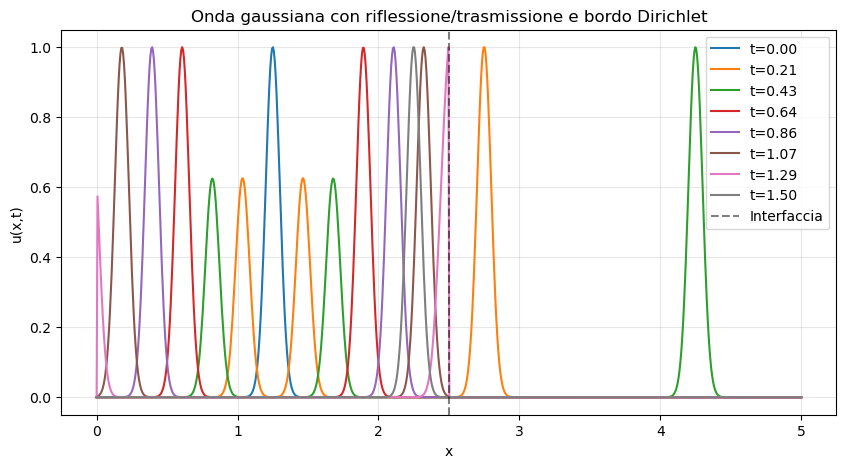

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri dominio
L = 5
nx = 800
x = np.linspace(0, L, nx)

# Parametri fisici
c1 = 1.0   # velocità nel primo mezzo
c2 = 4.0   # velocità nel secondo mezzo
x0 = L/4   # centro gaussiana iniziale
sigma = 0.05

# Coefficienti corretti
R = (c2 - c1) / (c1 + c2)   # riflessione all'interfaccia
T = (2 * c2) / (c1 + c2)    # trasmissione all'interfaccia

# Gaussiana
def gaussian(x, x0, sigma):
    return np.exp(-0.5 * ((x - x0) / sigma)**2)

def u_piecewise(x, t):
    u = np.zeros_like(x)
    for i, xi in enumerate(x):
        if xi < L/2:
            xi_inc = xi - c1*t
            xi_ref = (2*(L/2) - xi) - c1*t
            xi_left = xi + c1*t
            xi_left_ref = -xi_left
            u[i] = (
                gaussian(xi_inc, x0, sigma)
                + R * gaussian(xi_ref, x0, sigma)
                + gaussian(xi_left, x0, sigma)
                - gaussian(xi_left_ref, x0, sigma)
            )
        else:
            xi_tra = xi - c2*t - (c2 - c1)*t
            u[i] = T * gaussian(xi_tra, x0, sigma)

    u[0] = 0.0
    u[-1] = 0.0

    # Normalizzazione massima
    u /= np.max(np.abs(u))  
    return u

# Plot
plt.figure(figsize=(10,5))
for t in np.linspace(0, 1.5, 8):
    plt.plot(x, u_piecewise(x, t), label=f"t={t:.2f}")
plt.axvline(L/2, color="k", linestyle="--", alpha=0.5, label="Interfaccia")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Onda gaussiana con riflessione/trasmissione e bordo Dirichlet")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from ufl import MixedElement

# ----------------------- Utilities -----------------------

def gaussian_packet(x, x0, sigma, k0=0.0):
    """Complex Gaussian wave packet ψ(x) ∝ exp(-(x-x0)^2/(4σ^2)) * exp(i k0 (x-x0)).
    Returns (u, v) real/imag arrays and the normalization factor is applied to ensure ∫|ψ|^2=1 over domain.
    """
    # un-normalized envelope
    env = np.exp(- (x - x0)**2 / (4.0 * sigma**2))
    phase = k0 * (x - x0)
    u = env * np.cos(phase)
    v = env * np.sin(phase)
    # compute norm ∫|ψ|^2 dx ≈ sum |ψ|^2 Δx (use trapezoid later in FEM). We'll return raw; normalization will be done in FEM using mass matrix.
    return u, v

In [ ]:
# ----------------------- Core solver -----------------------

def tdse_1d(
    L=20.0,
    nx=2000,
    T=2.0,
    dt=0.002,
    hbar=1.0,
    m=1.0,
    V_func=None,   # callable V(x) or None for zero potential
    x0=5.0,
    sigma0=0.5,
    k0=0.0,
    bc_type="Dirichlet",  # or "Neumann" (natural)
    n_plots=6,
    plot_density=True,
):
    """Solve TDSE in 1D with Crank–Nicolson splitting real/imag.

    Returns time series of (t, sigma, mass) and final fields.
    """
    # Mesh and function spaces
    domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])
    V = fem.functionspace(domain, ("Lagrange", 1))
    W = fem.FunctionSpace(domain, MixedElement([V.ufl_element(), V.ufl_element()]))

    # Trial/Test
    U_trial = ufl.TrialFunction(W)   # (u^{n+1}, v^{n+1})
    Phi     = ufl.TestFunction(W)    # (φ_u, φ_v)
    u_trial, v_trial = ufl.split(U_trial)
    phi_u, phi_v     = ufl.split(Phi)

    # Functions (past/present)
    U_n = fem.Function(W)
    u_n, v_n = U_n.split()

    # Coordinates and initial condition
    x = V.tabulate_dof_coordinates()[:, 0]
    u0_vals, v0_vals = gaussian_packet(x, x0=x0, sigma=sigma0, k0=k0)

    # Project initial u,v into V
    u_init = fem.Function(V)
    v_init = fem.Function(V)
    u_init.x.array[:] = u0_vals
    v_init.x.array[:] = v0_vals

    # Interpolate into mixed function
    with U_n.vector.localForm() as loc:
        pass  # Touch vector to ensure allocation
    U_n.sub(0).interpolate(lambda X: np.exp(- (X[0]-x0)**2 / (4.0*sigma0**2)) * np.cos(k0*(X[0]-x0)))
    U_n.sub(1).interpolate(lambda X: np.exp(- (X[0]-x0)**2 / (4.0*sigma0**2)) * np.sin(k0*(X[0]-x0)))

    # Potential V(x)
    if V_func is None:
        V_fun = fem.Function(V)
        V_fun.x.array[:] = 0.0
    else:
        V_fun = fem.Function(V)
        V_fun.interpolate(lambda X: V_func(X[0]))

    # Parameters and operators
    dx = ufl.dx
    du = ufl.grad(u_trial)
    dv = ufl.grad(v_trial)
    phi_u_grad = ufl.grad(phi_u)
    phi_v_grad = ufl.grad(phi_v)

    # Operator A = - (ħ^2 / 2m) ∂xx + V
    alpha = (hbar**2) / (2.0*m)
    cfac = dt / (2.0*hbar)

    # Left-hand side (CN implicit part)
    a11 = ufl.inner(u_trial, phi_u) * dx                          # u^{n+1} * φ_u
    a12 = - cfac * ( alpha*ufl.inner(du, phi_u_grad) * dx + ufl.inner(V_fun*u_trial, phi_u) * dx )  # - (dt/2ħ) A v^{n+1} but with u_trial? (we need cross with v)
    a21 =  cfac * ( alpha*ufl.inner(ufl.grad(u_trial), phi_v_grad) * dx + ufl.inner(V_fun*u_trial, phi_v) * dx )  # + (dt/2ħ) A u^{n+1}
    a22 = ufl.inner(v_trial, phi_v) * dx

    # Wait: we must couple u_trial with phi_u and v_trial with phi_u for cross terms properly.
    # Re-define carefully using blocks:
    u = u_trial; v = v_trial

    a = (
        ufl.inner(u, phi_u) * dx
        + ufl.inner(v, phi_v) * dx
        # Cross-coupling from CN implicit terms:
        - cfac * ( alpha*ufl.inner(ufl.grad(v), phi_u_grad) * dx + ufl.inner(V_fun*v, phi_u) * dx )
        + cfac * ( alpha*ufl.inner(ufl.grad(u), phi_v_grad) * dx + ufl.inner(V_fun*u, phi_v) * dx )
    )

    # Right-hand side (explicit part with U_n)
    u_n_f, v_n_f = ufl.split(U_n)
    L_form = (
        ufl.inner(u_n_f, phi_u) * dx
        + ufl.inner(v_n_f, phi_v) * dx
        + cfac * ( alpha*ufl.inner(ufl.grad(v_n_f), phi_u_grad) * dx + ufl.inner(V_fun*v_n_f, phi_u) * dx )
        - cfac * ( alpha*ufl.inner(ufl.grad(u_n_f), phi_v_grad) * dx + ufl.inner(V_fun*u_n_f, phi_v) * dx )
    )

    # Boundary conditions
    bcs = []
    if bc_type == "Dirichlet":
        zero = fem.Function(V); zero.x.array[:] = 0.0
        # both ends
        facets = mesh.locate_entities_boundary(domain, 0, lambda X: np.isclose(X[0], 0.0) | np.isclose(X[0], L))
        dofs = fem.locate_dofs_topological((W.sub(0), V), 0, facets)
        bcs += [fem.dirichletbc(zero, dofs, W.sub(0))]
        dofs = fem.locate_dofs_topological((W.sub(1), V), 0, facets)
        bcs += [fem.dirichletbc(zero, dofs, W.sub(1))]

    # Assemble matrix once (time-independent V)
    A = fem_petsc.assemble_matrix(fem.form(a), bcs=bcs)
    A.assemble()

    # Prepare solver (symmetric indefinite-like but real). Use LU for robustness.
    ksp = PETSc.KSP().create(domain.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    ksp.getPC().setType("lu")

    # Assemble vector
    L_vec = fem_petsc.create_vector(fem.form(L_form))

    # Helpers for diagnostics
    def mass_form(u_f, v_f):
        return (u_f*u_f + v_f*v_f) * dx
    def exp_x_form(u_f, v_f, power=1):
        xcoord = ufl.SpatialCoordinate(domain)[0]
        if power == 1:
            return (xcoord * (u_f*u_f + v_f*v_f)) * dx
        else:
            return (xcoord**2 * (u_f*u_f + v_f*v_f)) * dx

    # Normalize initial state to 1 (mass = ∫|ψ|^2)
    mass0 = fem.assemble_scalar(fem.form(mass_form(u_n_f, v_n_f)))
    mass0 = domain.comm.allreduce(mass0, op=MPI.SUM)
    scale = 1.0/np.sqrt(mass0)
    U_n.sub(0).x.array[:] *= scale
    U_n.sub(1).x.array[:] *= scale

    # Time loop
    nt = int(np.round(T/dt)) + 1
    t_vals = np.linspace(0., T, nt)
    t_plots = np.linspace(0., T, n_plots)

    sigmas = []
    masses = []

    # Analytical σ(t) for free particle (if V=0)
    def sigma_free(t):
        return sigma0 * np.sqrt(1.0 + (hbar * t / (2.0 * m * sigma0**2))**2)

    # Plot setup
    if plot_density:
        plt.figure(figsize=(10,6))

    for t in t_vals:
        # Diagnostics and plotting at selected times
        if plot_density and np.any(np.isclose(t, t_plots, atol=dt/2)):
            u_view, v_view = U_n.split()
            rho = u_view.x.array**2 + v_view.x.array**2
            plt.plot(x, rho, label=f"t={t:.3f}")

        # Compute ⟨x⟩, ⟨x^2⟩, σ
        u_f, v_f = ufl.split(U_n)
        mass = fem.assemble_scalar(fem.form(mass_form(u_f, v_f)))
        mass = domain.comm.allreduce(mass, op=MPI.SUM)
        x1 = fem.assemble_scalar(fem.form(exp_x_form(u_f, v_f, power=1)))
        x1 = domain.comm.allreduce(x1, op=MPI.SUM) / mass
        x2 = fem.assemble_scalar(fem.form(exp_x_form(u_f, v_f, power=2)))
        x2 = domain.comm.allreduce(x2, op=MPI.SUM) / mass
        sigma = np.sqrt(max(0.0, x2 - x1**2))
        sigmas.append((t, sigma))
        masses.append((t, mass))

        if np.isclose(t, T):
            break  # do not advance at final time

        # Build RHS
        L_vec.zeroEntries()
        fem_petsc.assemble_vector(L_vec, fem.form(L_form))
        fem_petsc.apply_lifting(L_vec, [fem.form(a)], bcs=[bcs])
        L_vec.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem_petsc.set_bc(L_vec, bcs)

        # Solve A U^{n+1} = b
        U_np1 = fem.Function(W)
        ksp.solve(L_vec, U_np1.vector)
        U_np1.x.scatter_forward()

        # Update
        U_n.x.array[:] = U_np1.x.array

    if plot_density:
        plt.xlabel("x")
        plt.ylabel(r"$|\psi(x,t)|^2$")
        plt.title("TDSE 1D — probability density (Crank–Nicolson)")
        plt.legend(); plt.grid(True); plt.show()

    # Plot sigma(t) and free-theory if V=0
    ts = np.array([t for t,_ in sigmas])
    svals = np.array([s for _,s in sigmas])
    plt.figure(figsize=(8,5))
    plt.plot(ts, svals, label=r"$\sigma(t)$ (FEM)")
    if V_func is None:
        plt.plot(ts, [sigma_free(tt) for tt in ts], linestyle='--', label=r"free theory")
    plt.xlabel("t"); plt.ylabel(r"$\sigma(t)$"); plt.title("Wave packet width vs time"); plt.legend(); plt.grid(True); plt.show()

    return {
        "times": ts,
        "sigma": svals,
        "mass": np.array([m for _,m in masses]),
        "final_state": U_n
    }

In [ ]:
# ----------------------- Example run (Free particle) -----------------------
if __name__ == "__main__":
    L = 40.0
    nx = 3000
    T  = 4.0
    dt = 0.002
    hbar = 1.0
    m = 1.0
    x0 = 10.0
    sigma0 = 0.7
    k0 = 5.0   # give some momentum so the packet drifts; set 0.0 to see symmetric spreading

    result = tdse_1d(L=L, nx=nx, T=T, dt=dt, hbar=hbar, m=m,
                     V_func=None, x0=x0, sigma0=sigma0, k0=k0,
                     bc_type="Dirichlet", n_plots=6, plot_density=True)

    # Print basic diagnostics
    print(f"Mass conservation: m(0)={result['mass'][0]:.6f}, m(T)={result['mass'][-1]:.6f}")
    print(f"Initial sigma={result['sigma'][0]:.4f}, Final sigma={result['sigma'][-1]:.4f}")

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from mpi4py import MPI
from dolfinx import mesh, fem
from dolfinx.fem import petsc as fem_petsc
import ufl
import numpy as np
from petsc4py import PETSc

# ---------------------------
# Parametri fisici e numerici
# ---------------------------
hbar = 1.0
m    = 1.0
beta = hbar / (2.0 * m)      # compare nelle equazioni: u_t = -beta * Delta v, v_t = +beta * Delta u

L, nx = 5.0, 500
dt    = 0.001
T     = 1.0
nt    = int(T / dt) + 1

# ---------------------------
# dominio e spazi scalari W
# ---------------------------
domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])
W      = fem.functionspace(domain, ("Lagrange", 1))

# ---------------------------
# Funzioni reali: u,v (present/future)
# ---------------------------
u_present = fem.Function(W)
v_present = fem.Function(W)
u_future  = fem.Function(W)
v_future  = fem.Function(W)

# coordinate e inizializzazione (pacchetto gaussiano con fase)
x = W.tabulate_dof_coordinates()[:, 0]
x0, k0, sigma = L/2.0, 5.0, 0.25
psi0 = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
u_present.x.array[:] = np.real(psi0)
v_present.x.array[:] = np.imag(psi0)

# ---------------------------
# Assemblaggio di M e K (reali)
# ---------------------------
u = ufl.TrialFunction(W)
v = ufl.TestFunction(W)

M_form = u * v * ufl.dx
K_form = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

M = fem_petsc.assemble_matrix(fem.form(M_form))
M.assemble()
K = fem_petsc.assemble_matrix(fem.form(K_form))
K.assemble()

# ---------------------------
# Costruzione dei blocchi A e B
# CN: gamma = dt*beta/2
# A = [[M, +gamma K], [-gamma K, M]]
# B = [[M, -gamma K], [+gamma K, M]]
# ---------------------------
gamma = dt * beta / 2.0

# Cpos = gamma * K
Cpos = K.copy()
Cpos.scale(gamma)   # reale -> ok con PETSc real-only

# costruiamo blocchi come matrici PETSc (usiamo createNest)
# nota: M, Cpos, -Cpos sono PETSc.Mat
Ablocks = [[M,              Cpos],
           [(-Cpos).copy(), M]]   # usiamo una copia per il -Cpos in basso sinistro

# il -Cpos creato sopra: (IMPORTANT) (-Cpos).copy() restituisce la copia con segno negativo
# per sicurezza, creo D = K.copy(); D.scale(-gamma) e lo uso:
D = K.copy()
D.scale(-gamma)
Ablocks = [[M, Cpos],
           [D, M]]

Bblocks = [[M, -Cpos],
           [Cpos, M]]

# crea le matrici Nest (bloccate)
A_mat = PETSc.Mat().createNest(Ablocks, comm = domain.comm)
A_mat.setUp()
A_mat.assemble()

B_mat = PETSc.Mat().createNest(Bblocks, comm = domain.comm)
B_mat.setUp()
B_mat.assemble()

# ---------------------------
# Costruzione di vettori annidati (Vec.createNest)
# Ogni componente è il PETSc.Vec associato alle fem.Function
# ---------------------------
u_n_vec   = u_present.x.petsc_vec
v_n_vec   = v_present.x.petsc_vec
u_np1_vec = u_future.x.petsc_vec
v_np1_vec = v_future.x.petsc_vec

# Vettore di stato corrente X^n (annidato)
Xn = PETSc.Vec().createNest([u_n_vec, v_n_vec], comm = domain.comm)

# Vettore destinazione X^{n+1} (annidato) - usa i vec di destinazione delle funzioni future
Xnp1 = PETSc.Vec().createNest([u_np1_vec, v_np1_vec], comm = domain.comm)

# Vettore RHS annidato (creiamo una nuova istanza con la stessa struttura)
RHS = PETSc.Vec().createNest([u_np1_vec.duplicate(), v_np1_vec.duplicate()], comm = domain.comm)

# ---------------------------
# Solver KSP su A_mat
# ---------------------------
ksp = PETSc.KSP().create(domain.comm)
ksp.setOperators(A_mat)
ksp.setType("preonly")
ksp.getPC().setType("lu")
ksp.setFromOptions()

# ---------------------------
# Funzione per norma L2 totale (probabilità)
# ---------------------------
mass_form = ufl.inner(u, v) * ufl.dx  # semplice M forma per L2
# sfruttiamo M e il vettore [u^2+v^2] -> ma useremo quadratura con numpy sui dof (semplice)
coords = x  # già presi
h = L / nx

def total_probability(u_fun, v_fun):
    # approssimazione semplice: trapz sui dof (sufficiente per controllo qualitativo)
    uu = u_fun.x.array
    vv = v_fun.x.array
    return np.trapezoid(uu**2 + vv**2, coords)

print("Initial total probability: ", total_probability(u_present, v_present))

# scegli istanti da plottare
snapshots = [0, int(nt/4), int(nt/2), nt-1]
results = {}

for n in range(nt):
    # compute RHS = B * Xn
    B_mat.mult(Xn, RHS)
    ksp.solve(RHS, Xnp1)

    u_future.x.scatter_forward()
    v_future.x.scatter_forward()

    # salva risultati a istanti scelti
    if n in snapshots:
        psi = u_future.x.array + 1j * v_future.x.array
        results[n] = psi.copy()

    # update present <- future
    u_present.x.array[:] = u_future.x.array
    v_present.x.array[:] = v_future.x.array

# --- Plot ---
plt.figure(figsize=(10,6))
for n, psi in results.items():
    plt.plot(x, np.abs(psi)**2, label=f"t={n*dt:.3f}")
plt.xlabel("x")
plt.ylabel(r"$|\psi(x,t)|^2$")
plt.legend()
plt.title("Evoluzione densità di probabilità")
plt.show()


In [ ]:
hbar = 1.0
m    = 1.0
beta = hbar / (2.0 * m)
L    = 50.0
nx   = 1000 
dt   = 0.001
T    = 5.0
nt   = int(T / dt) + 1

# ---------------------------
# dominio e spazi scalari
# ---------------------------
domain = mesh.create_interval(MPI.COMM_WORLD, nx, [-L/2, L/2]) 
W      = fem.functionspace(domain, ("Lagrange", 1))

# ---------------------------
# Condizioni al contorno
# ---------------------------

bc_type = "Dirichlet"
bc_list = []

if bc_type == "Neumann":

    bc_list = []
    
elif bc_type == "Dirichlet":

    u_bc = fem.Function(W)
    u_bc.x.array[:] = 0.0
    
    facets = mesh.locate_entities_boundary(
        domain,
        dim=0,
        marker=lambda x: np.isclose(x[0], -L/2) | np.isclose(x[0], L/2)
    )
    
    dofs = fem.locate_dofs_topological(W, entity_dim=0, entities=facets)
    bc_list = [fem.dirichletbc(u_bc, dofs)]

# ---------------------------
# Funzioni reali
# ---------------------------
u_present = fem.Function(W)
v_present = fem.Function(W)
u_future = fem.Function(W)
v_future = fem.Function(W)

# Inizializzazione (pacchetto gaussiano centrato)
x_coords = W.tabulate_dof_coordinates()[:, 0]
x0 = 0.0
k0 = 0.0
sigma = 1
psi0 = np.exp(-(x_coords - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x_coords)
u_present.x.array[:] = np.real(psi0)
v_present.x.array[:] = np.imag(psi0)

# ---------------------------
# Forme bilineari e lineari
# ---------------------------
u = ufl.TrialFunction(W)
w = ufl.TestFunction(W)

# Matrice di massa
M_form = u * w * ufl.dx
M = fem_petsc.assemble_matrix(fem.form(M_form), bcs = bc_list)
M.assemble()

# Matrice di rigidità
K_form = ufl.inner(ufl.grad(u), ufl.grad(w)) * ufl.dx
K = fem_petsc.assemble_matrix(fem.form(K_form), bcs = bc_list)
K.assemble()

V_form = fem.Constant(domain, 0.0) * u * w * ufl.dx
V_matrix = fem_petsc.assemble_matrix(fem.form(V_form), bcs = bc_list)
V_matrix.assemble()

H = K.copy()
H.scale(-beta)

alpha = dt / (2*hbar)

# Matrici lato destro e sinistro
A = M.copy()
A.aypx(alpha, H)  # A = M + alpha*H
B = M.copy()
B.axpy(-alpha, H) # B = M - alpha*H

# Concatenazione [u; v]
psi = np.concatenate([u_present.x.array, v_present.x.array])
psi_new = np.zeros_like(psi)

# Sistema a blocchi (2x2)
size = len(u_present.x.array)

# Lato sinistro (A)
A_block = PETSc.Mat().createNest([[M, -alpha*H],
                                  [alpha*H, M]], comm=domain.comm)
A_block.assemble()

# Lato destro (B)
B_block = PETSc.Mat().createNest([[M, alpha*H],
                                  [-alpha*H, M]], comm=domain.comm)
B_block.assemble()

# Solutore
ksp = PETSc.KSP().create(domain.comm)
ksp.setOperators(A_block)
ksp.setType('preonly')
ksp.getPC().setType('lu')

# Create PETSc vectors
b = PETSc.Vec().create(comm=domain.comm)
b.setSizes(2*size)
b.setUp()
x = PETSc.Vec().create(comm=domain.comm)
x.setSizes(2*size)
x.setUp()

# Create temporary vector for matrix multiplication
temp_vec = PETSc.Vec().createWithArray(psi.copy(), comm=domain.comm)

plt.figure(figsize=(10,6))

for n in range(nt):
    # Costruisci lato destro: b = B_block * psi_n
    B_block.mult(temp_vec, b)  # Matrix-vector multiplication
    
    # Risolvi A_block * psi_{n+1} = b
    ksp.solve(b, x)
    
    # Aggiorna psi per il prossimo passo temporale
    temp_vec.setArray(x.getArray())
    psi[:] = x.getArray()
    
    # opzionale: salva o calcola sigma(t)
    u_present.x.array[:] = psi[:size]
    v_present.x.array[:] = psi[size:]
    
    prob_density = psi[:size]**2 + psi[size:]**2
    norm = np.sum(prob_density)

    x_mean = np.sum(x_coords * prob_density) / norm
    x2_mean = np.sum((x_coords**2) * prob_density) / norm
    sigma_t = np.sqrt(x2_mean - x_mean**2)

    if n % 500 == 0:
        print(f"t={n*dt:.3f}, sigma={sigma_t:.4f}")
        plt.plot(x_coords, prob_density, label=f"t={n:.3f}")
        
plt.xlabel("x")
plt.ylabel(r"$|\psi(x,t)|^2$")
plt.title("Pacchetto d'onda dopo evoluzione (Crank-Nicolson)")
plt.legend()
plt.grid(True)

plt.show()

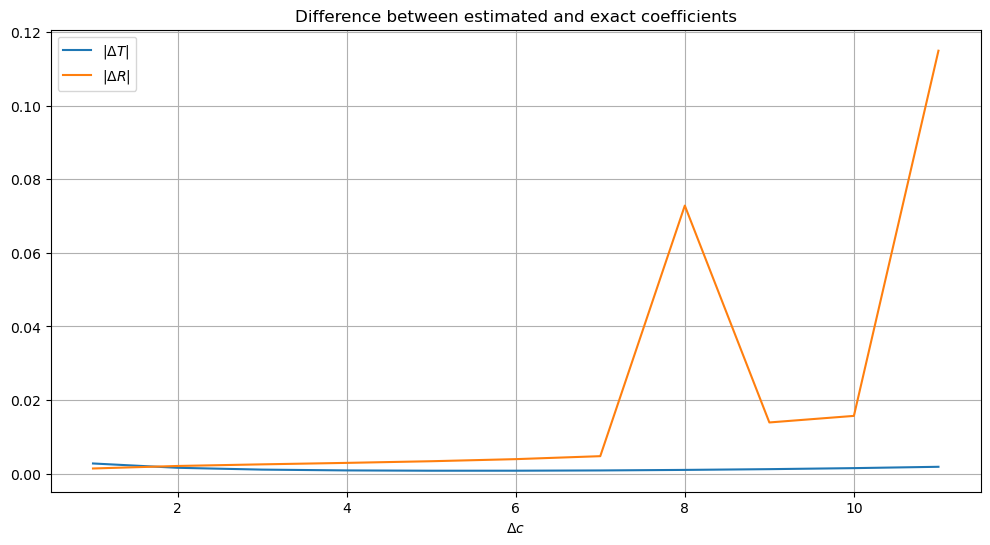

In [25]:
import matplotlib.pyplot as plt

T_approximated = [0.663904594111694, 0.49841099637911057, 0.3989067832639835, 0.33245686125275903, 0.28492170873590567, 0.2492025714836435, 0.22135364567278648, 0.1989854778700653, 0.18059794947575358, 0.16516981803570135, 0.15198527780843316]

R_approximated = [-0.33193089420155497, -0.49791690871848315, -0.5974750057300694, -0.6637422181603936, -0.7109128582661864, -0.7460599976045976, -0.7730295401693947, -0.72713463130826, -0.804266691886363, -0.8176357202154814, -0.9611204088561893]

T_exact = [0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222, 0.2, 0.18181818181818182, 0.16666666666666666, 0.15384615384615385]

R_exact = [-0.3333333333333333, -0.5, -0.6, -0.6666666666666666, -0.7142857142857143, -0.75, -0.7777777777777778, -0.8, -0.8181818181818182, -0.8333333333333334, -0.8461538461538461]

T_deltas = [abs(a-e) for a,e in zip(T_approximated, T_exact)]
R_deltas = [abs(a-e) for a,e in zip(R_approximated, R_exact)]

plt.figure(figsize = (12,6))

plt.plot(range(1, len(T_deltas)+1), T_deltas, label = r"$|\Delta T|$")
plt.plot(range(1, len(R_deltas)+1), R_deltas, label = r"$|\Delta R|$")

plt.xlabel(r"$\Delta c$")
plt.title("Difference between estimated and exact coefficients")
plt.grid()
plt.legend()
plt.show()

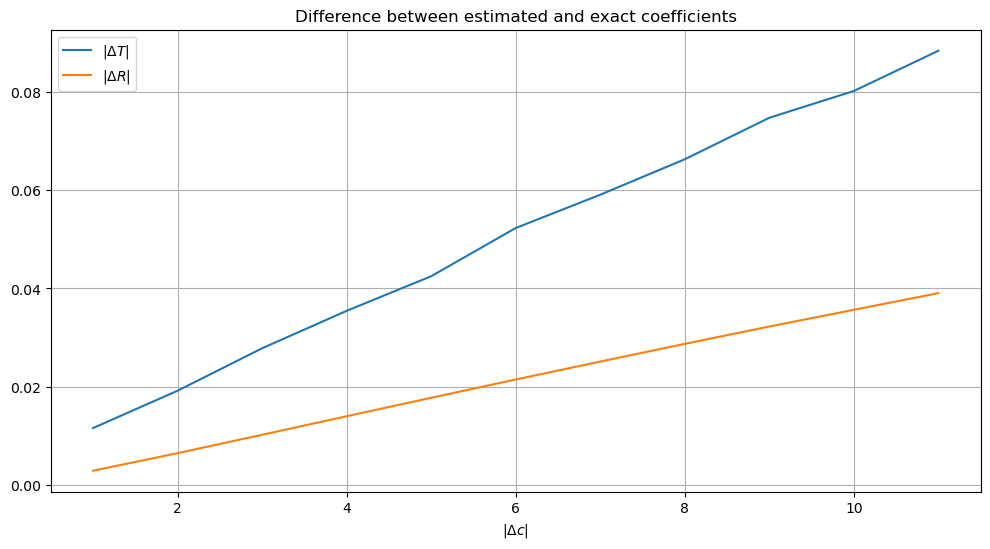

In [26]:
T_approximated = [1.32172613636923, 1.480798465977241, 1.5721672467914873, 1.631214502933794, 1.6717959218571659, 1.6977034246352618, 1.7187078119788333, 1.7337206797066846, 1.7434600362319101, 1.7531623207751041, 1.7577995508060293]

R_approximated = [0.3303986132459054, 0.49349377163866937, 0.589755984459352, 0.6526470048448054, 0.6965139997467811, 0.7285132197701752, 0.7526422483758866, 0.7712591266053638, 0.7859139744207815, 0.7976655999333546, 0.8070973267962429]

T_exact = [1.3333333333333333, 1.5, 1.6, 1.6666666666666667, 1.7142857142857142, 1.75, 1.7777777777777777, 1.8, 1.8181818181818181, 1.8333333333333333, 1.8461538461538463]

R_exact = [0.3333333333333333, 0.5, 0.6, 0.6666666666666666, 0.7142857142857143, 0.75, 0.7777777777777778, 0.8, 0.8181818181818182, 0.8333333333333334, 0.8461538461538461]

T_deltas = [abs(a-e) for a,e in zip(T_approximated, T_exact)]
R_deltas = [abs(a-e) for a,e in zip(R_approximated, R_exact)]

plt.figure(figsize = (12,6))

plt.plot(range(1, len(T_deltas)+1), T_deltas, label = r"$|\Delta T|$")
plt.plot(range(1, len(R_deltas)+1), R_deltas, label = r"$|\Delta R|$")

plt.xlabel(r"$|\Delta c|$")
plt.title("Difference between estimated and exact coefficients")
plt.grid()
plt.legend()
plt.show()

In [27]:
from dolfinx import mesh, fem
from dolfinx.fem import petsc as fem_petsc
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.stats import linregress

In [28]:
# Gaussian function
def gaussian(x, x0, sigma):
    return 1/(np.sqrt(2*np.pi) * sigma) * np.exp(-0.5 * ((x - x0) / sigma)**2)

# Constant piecewise function
def c_piecewise(x, c1, c2, L):
    return np.where(x < L/2, c1, c2)

In [41]:
def plot_energies(L, nx, T, dt, c, f, bc = "Dirichlet"):
    
    # Physics domain and function space
    domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0.0, L])
    V      = fem.functionspace(domain, ("Lagrange", 1))
    
    # Boundary conditions
    bc_list = []
    
    if bc == "Neumann":
        
        bc_list = []
    
    elif bc == "Dirichlet":
        
        u_bc            = fem.Function(V)
        u_bc.x.array[:] = 0.0
        
        facets = mesh.locate_entities_boundary(
            domain,
            dim    = 0,
            marker = lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
        )
        
        dofs    = fem.locate_dofs_topological(V, entity_dim = 0, entities = facets)
        bc_list = [fem.dirichletbc(u_bc, dofs)]
        
    # Function at different time steps
    u_past    = fem.Function(V)   # u_{i-1}
    u_present = fem.Function(V)   # u_{i}
    u_future  = fem.Function(V)   # u_{i+1}
    
    # Inizialization
    x_coords             = V.tabulate_dof_coordinates()[:, 0]
    u_past.x.array[:]    = f(x_coords)
    u_present.x.array[:] = u_past.x.array   # Inizial velocity v = 0
    
    # Velocity
    
    # Constant velocity
    if np.isscalar(c):
        
        c2   = fem.Constant(domain, PETSc.ScalarType(c**2))
        wall = False
        
        v_max = c
       
    # Generical function
    else:
        
        c_fun = fem.Function(V)
        wall  = True
        
        if callable(c):
            c_fun.interpolate(lambda x: c(x[0])**2)
        else:
            c_fun.x.array[:] = np.asarray(c(x_coords))**2
            
        c2 = c_fun
        
        v_max = np.sqrt(np.max([c_fun.x.array[0], c_fun.x.array[-1]]))
        
    # CFL check
    CFL = v_max*dt / (L/nx)
    print(f"CFL = {CFL:.3f}\n")
    
    # Functions in weak form
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    
    # Constant matrix A
    a_form = (u*v / dt**2) * ufl.dx + c2 * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
    A      = fem_petsc.assemble_matrix(fem.form(a_form), bcs = bc_list)
    A.assemble()
    
    # Solving through LU decomposition
    solver = PETSc.KSP().create(domain.comm)
    solver.setOperators(A)
    solver.setType("preonly")
    solver.getPC().setType("lu")
    
    # Time values
    nt      = int(T / dt) + 1
    t_vals  = np.linspace(0.0, T, nt)
    
    # Setup to transmitting and reflecting coefficients evaluation
    if wall == True:
        i_mid   = np.argmin(np.abs(x_coords - L/2))
        i_left  = np.argmin(np.abs(x_coords - L/4))       
        i_right = np.argmin(np.abs(x_coords - 3*L/4))
        
        t_cross       = None
        t_transmitted = None
        t_reflected   = None
        
        initial_amplitude     = None
        transmitted_amplitude = None
        reflected_amplitude   = None
        
        threshold = 0.05
    
    else:
        t_cross = None
        
    # Setup for energies storing
    energies = []
    
    # Plot figure
    plt.figure(figsize = (10, 6))
    
    # Temporal loop
    for t_current in t_vals:
            
        # Energies
        u_t            = fem.Function(V)
        u_t.x.array[:] = (u_present.x.array - u_past.x.array) / dt
            
        energy_form = 0.5 * ((u_t**2) / c2 + ufl.inner(ufl.grad(u_present), ufl.grad(u_present))) * ufl.dx
        E           = fem.assemble_scalar(fem.form(energy_form))
            
        if t_current == 0.0:
            E0 = E
                
        energies.append(E/E0)

        # Skip last temporal step
        if np.isclose(t_current, T):
            break

        # Right hand side
        L_form = (2.0 * u_present * v / dt**2 - u_past * v / dt**2) * ufl.dx
        b      = fem_petsc.assemble_vector(fem.form(L_form))
        fem_petsc.apply_lifting(b, [fem.form(a_form)], bcs = [bc_list])
        b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
        fem_petsc.set_bc(b, bc_list)

        # Solution
        solver.solve(b, u_future.x.petsc_vec)
        u_future.x.scatter_forward()

        # Update for new time step
        u_past.x.array[:]    = u_present.x.array
        u_present.x.array[:] = u_future.x.array
        
        # Evaluation of transmissing and reflecting coefficients
        if wall == True:
            
            umax = np.max(np.abs(u_present.x.array))
            
            if t_cross is None and np.abs(u_present.x.array[i_mid]) > threshold * umax:
                t_cross           = t_current
                initial_amplitude = umax
                
            if t_cross is not None and transmitted_amplitude is None:
                u_mid   = u_present.x.array[i_mid]
                u_right = u_present.x.array[i_right]
                
                if np.isclose(u_mid, u_right, rtol = 1e-2):
                    transmitted_amplitude = np.max(np.abs(u_present.x.array[i_mid:i_right+1]))
                    t_transmitted         = t_current
            
            if t_cross is not None and reflected_amplitude is None:
                u_mid  = u_present.x.array[i_mid]
                u_left = u_present.x.array[i_left]
                
                if np.isclose(u_mid, u_left, rtol = 1e-2):
                    reflected_amplitude = np.max(np.abs(u_present.x.array[i_left:i_mid+1]))
                    t_reflected         = t_current
                    
    if t_cross is None:
        wall = False
        if np.isscalar(c) == False:
            print("\nThe time was not enough for the wave to cross the wall")

    plt.plot(t_vals, energies)
    plt.axvline(t_cross, color = "k", linestyle = "--", alpha = 0.5, label = "Crossing time")
    
    plt.title(f"Energy evaluation with respect to time")
    plt.xlabel("t")
    plt.ylabel(r"$E/E_0$")
    plt.grid()
    plt.legend()
    plt.show()

In [70]:
L     = 5.0
nx    = 5000
T     = 0.3
dt    = 0.00005
c1    = 9.0
c2    = 1.0
c_fun = partial(c_piecewise, c1 = c1, c2 = c2, L = L)
bc    = "Neumann"

CFL = 0.450



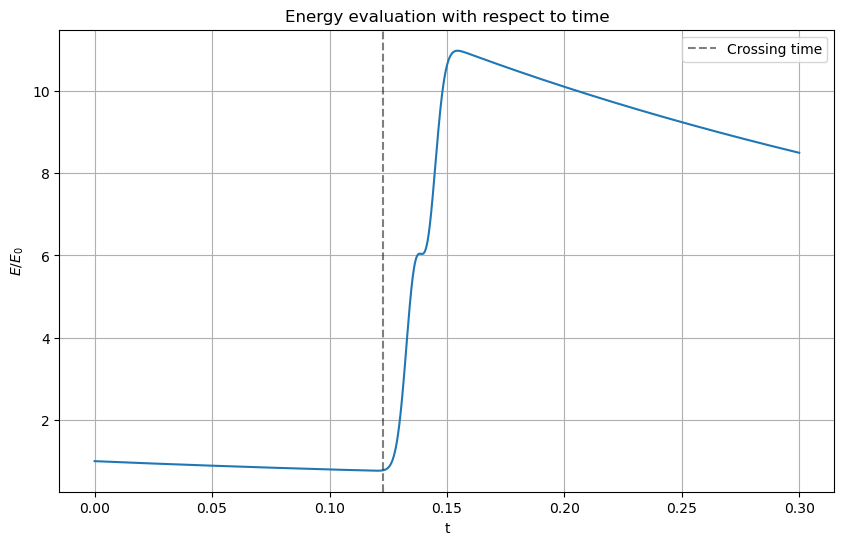

In [71]:
plot_energies(
    L  = L,
    nx = nx,
    T  = T,
    dt = dt,
    c  = c_fun,
    f  = lambda x: gaussian(x, x0 = L/4, sigma = 0.05),
    bc = "Dirichlet"
)

In [72]:
def calculate_effective_mass(V0, a, hbar = 1.0, m = 1.0, G_max = 10, k_range = 0.1, n_k = 21):
    
    G_values = np.arange(-G_max, G_max+1) * (2*np.pi/a)
    nG       = len(G_values)
    
    V_matrix = np.zeros((nG, nG), dtype = complex)
    for i, Gi in enumerate(G_values):
        for j, Gj in enumerate(G_values):
            
            delta_G = Gi - Gj

            if np.isclose(delta_G, 2*np.pi/a) or np.isclose(delta_G, -2*np.pi/a):
                V_matrix[i, j] = V0 / 2.0
    
    k_points = np.linspace(-k_range*np.pi/a, k_range*np.pi/a, n_k)
    E_k      = []
    
    for k in k_points:

        H_k = V_matrix.copy()
        for i, Gi in enumerate(G_values):
            H_k[i, i] += (hbar**2 * (k + Gi)**2) / (2*m)
        
        eigenvalues, _ = eigh(H_k)
        E_k.append(eigenvalues[0]) 
    
    E_k = np.array(E_k)
    
    coeffs  = np.polyfit(k_points, E_k, 2)
    d2E_dk2 = 2*coeffs[0]
    m_eff   = hbar**2 / d2E_dk2
    E0      = coeffs[2] 
    
    return m_eff, E0, k_points, E_k

In [80]:
def ballistic_behaviour(L, nx, x0, sigma, k0, T, dt, hbar = 1.0, m = 1.0, bc = "Dirichlet", potential_type = "Free-particle", V0 = 1.0, a = 1.0, F = 1.0):
    
    domain = mesh.create_interval(MPI.COMM_WORLD, nx, [-L/2, L/2]) 
    W      = fem.functionspace(domain, ("Lagrange", 1))
    
    if bc == "Dirichlet":
        
        u_bc            = fem.Function(W)
        u_bc.x.array[:] = 0.0
        
        facets = mesh.locate_entities_boundary(
            domain,
            dim    = 0,
            marker = lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
        )
        
        dofs    = fem.locate_dofs_topological(W, entity_dim = 0, entities = facets)
        bc_list = [fem.dirichletbc(u_bc, dofs)]
        
    elif bc == "Neumann":
        
        bc_list = []
        
    elif bc == "Absorbing":
        
        bc_list = []
        
    u_present = fem.Function(W)
    v_present = fem.Function(W)
    
    x_coords             = W.tabulate_dof_coordinates()[:, 0]
    psi0                 = 1 / ((np.pi * (sigma**2)) ** (1/4)) * np.exp(-(x_coords - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x_coords)
    u_present.x.array[:] = np.real(psi0)
    v_present.x.array[:] = np.imag(psi0)
    
    u = ufl.TrialFunction(W)
    w = ufl.TestFunction(W)
    
    M_form = u * w * ufl.dx
    M      = fem_petsc.assemble_matrix(fem.form(M_form), bcs = bc_list)
    M.assemble()
    
    K_form = ufl.inner(ufl.grad(u), ufl.grad(w)) * ufl.dx
    K      = fem_petsc.assemble_matrix(fem.form(K_form), bcs = bc_list)
    K.assemble()
    
    if potential_type == "Free-particle":
        V_expr = fem.Constant(domain, 0.0)
        
    elif potential_type == "Periodic":
        x      = ufl.SpatialCoordinate(domain)[0]
        V_expr = V0 * ufl.cos(2 * np.pi * x / a)
        
    elif potential_type == "Linear":
        x      = ufl.SpatialCoordinate(domain)[0]
        V_expr = (V0 * ufl.cos(2 * np.pi * x / a)) + (F * x)
    
    V_form   = V_expr * u * w * ufl.dx
    V_matrix = fem_petsc.assemble_matrix(fem.form(V_form), bcs = bc_list)
    V_matrix.assemble()
    
    if bc == "Absorbing":
        x      = ufl.SpatialCoordinate(domain)[0]
        width  = 0.25 * L
        eta    = V0 * ufl.conditional(ufl.ge(ufl.sqrt(x**2), L/2 - width),
                                    ((ufl.sqrt(x**2) - (L/2 - width)) / width)**4,
                                    0.0)

        Abs_form   = eta * u * w * ufl.dx
        Abs_matrix = fem_petsc.assemble_matrix(fem.form(Abs_form), bcs = bc_list)
        Abs_matrix.assemble()
    
    alpha = dt / (2.0*hbar)
    beta  = hbar / (2.0*m)
    
    H = K.copy()
    H.scale(-beta)
    H.axpy(1.0, V_matrix)
    
    A = M.copy()
    A.aypx(alpha, H) 
     
    B = M.copy()
    B.axpy(-alpha, H)
    
    psi = np.concatenate([u_present.x.array, v_present.x.array])
        
    if bc == "Absorbing":
        A_block = PETSc.Mat().createNest([[M + alpha*Abs_matrix, -alpha*H],
                                         [alpha*H, M + alpha*Abs_matrix]], comm = domain.comm)
        B_block = PETSc.Mat().createNest([[M - alpha*Abs_matrix, alpha*H],
                                         [-alpha*H, M - alpha*Abs_matrix]], comm = domain.comm)
    else:
        A_block = PETSc.Mat().createNest([[M, -alpha*H],
                                         [alpha*H, M]], comm = domain.comm)
        B_block = PETSc.Mat().createNest([[M, alpha*H],
                                         [-alpha*H, M]], comm = domain.comm)

    A_block.assemble()
    B_block.assemble()
    
    ksp = PETSc.KSP().create(domain.comm)
    ksp.setOperators(A_block)
    ksp.setType('preonly')
    ksp.getPC().setType('lu')
    
    b = PETSc.Vec().create(comm = domain.comm)
    b.setSizes(2 * len(u_present.x.array))
    b.setUp()
    
    x = PETSc.Vec().create(comm = domain.comm)
    x.setSizes(2 * len(u_present.x.array))
    x.setUp()
    
    temp_vec = PETSc.Vec().createWithArray(psi.copy(), comm = domain.comm)
    
    nt      = int(T / dt) + 1
    t_vals  = np.linspace(0.0, T, nt)
    
    if potential_type == "Periodic":
        m_eff, E0, _, _ = calculate_effective_mass(V0, a, hbar, m, G_max = 10)
        print(f"Effective mass:     {m_eff:.3f}")
        print(f"Fundamental energy: {E0:.3f}\n")
    
    plt.figure(figsize = (13,6))
    
    sigmas          = []
    sigmas_expected = []
    
    for t_current in t_vals:

        B_block.mult(temp_vec, b)
        
        ksp.solve(b, x)
        
        temp_vec.setArray(x.getArray())
        psi[:] = x.getArray()
        
        u_present.x.array[:] = psi[:len(u_present.x.array)]
        v_present.x.array[:] = psi[len(u_present.x.array):]
        
        prob_density = u_present.x.array**2 + v_present.x.array**2
        norm         = np.sum(prob_density)

        x_mean  = np.sum(x_coords * prob_density) / norm
        
        x2_mean = np.sum((x_coords**2) * prob_density) / norm
        sigma_t = np.sqrt(x2_mean - x_mean**2)
        sigmas.append(sigma_t)
        
        if (potential_type == "Free-particle") | (potential_type == "Linear"):
            sigma_expected = np.sqrt((sigma**2) / 2 + ((hbar * t_current) / (np.sqrt(2) * m * sigma))**2)
            
        elif potential_type == "Periodic":
            sigma_expected = np.sqrt((sigma**2) / 2 + ((hbar * t_current) / (np.sqrt(2) * m_eff * sigma))**2)

        sigmas_expected.append(sigma_expected)
        
    diffs = [np.abs(i-j) for i,j in zip(sigmas,sigmas_expected)]
    
    plt.plot(t_vals, diffs)
    
    plt.title("Difference between expected and numerical standard deviation")
    plt.xlabel(r"$\Delta\sigma$")
    plt.grid()
    plt.show()

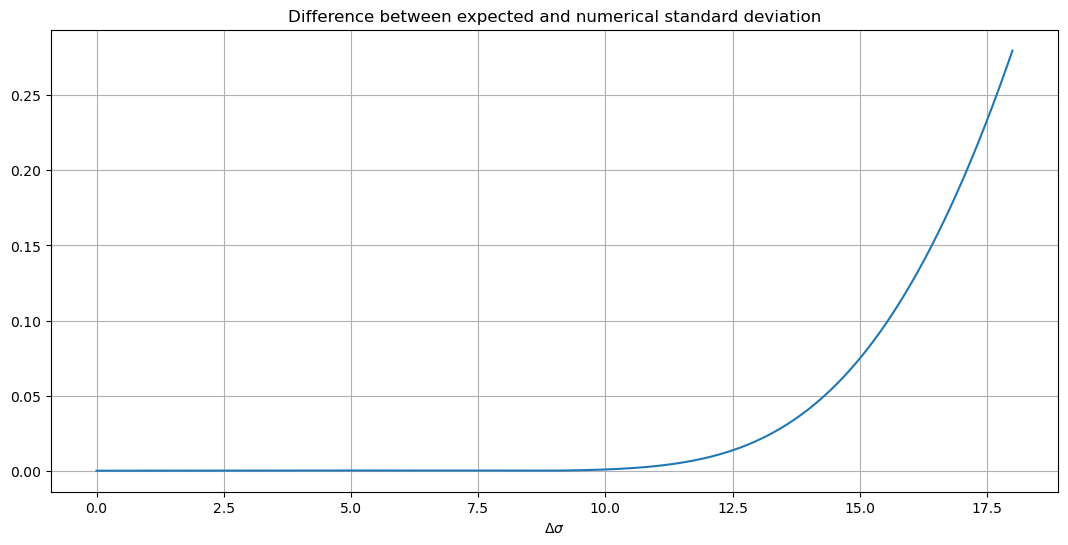

In [83]:
ballistic_behaviour(
    L              = 40.0,
    nx             = 4000,
    x0             = 0.0, 
    sigma          = 2,
    k0             = 0.0,
    T              = 18,
    dt             = 0.0005,
    hbar           = 1.0,
    m              = 1.0,
    bc             = "Absorbing",
    potential_type = "Free-particle",
    V0             = 1.0,
    a              = 2.0,
    F              = 2.0
)